<a href="https://colab.research.google.com/github/yubars/ML-and-Cybersecurity-projects/blob/main/IDS_using_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection System using ML model to predict attacks
#### Using KDD dataset to predict attacks correctly.

### Learning Objectives
* Learn to create and evaluate Intrusion Detection System (IDS) using  Naive Bayes Classifier.
* Visualize the predictions made by the algorithm with Confusion Matrix and performance metrics.


### Imports

Import all the required libraries including pandas, numpy, and matplotlib for the lab.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

### Mount Google Drive

In the code cell below, we mount the google drive to the colab environment so that we have access to the local version of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read CSV

We read the csv file using pandas in the code below.

In [ ]:
mydata = pd.read_csv('/content/drive/MyDrive/Intro2MLDatasets/Lab5/KDDCup99.csv')

### Analyzing Dataset

This code allows us to see the length and width of the dataset. The first integer denotes the number of rows and the second integer denotes the number of columns in the dataset.

In [ ]:
mydata.shape

(494020, 42)

The code cells below help us visualize the dataest in every angle. We use the given functions from pandas to display the shape, first 100 data, and the features in the dataset.

In [ ]:
mydata.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,lnum_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,tcp,http,SF,337,330,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,12,0.0,0.0,0.0,0.0,1.0,0.0,0.00,12,255,1.0,0.0,0.08,0.01,0.0,0.0,0.0,0.0,normal
96,0,tcp,http,SF,293,38125,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22,22,0.0,0.0,0.0,0.0,1.0,0.0,0.00,22,255,1.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,normal
97,0,tcp,http,SF,171,280,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,26,0.0,0.0,0.0,0.0,1.0,0.0,0.08,6,255,1.0,0.0,0.17,0.02,0.0,0.0,0.0,0.0,normal
98,0,tcp,http,SF,178,1973,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,16,255,1.0,0.0,0.06,0.02,0.0,0.0,0.0,0.0,normal


In [ ]:
mydata.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

### Identify Features to drop

In the code below, we identify the features which are same in every instances. 'lnum_outbound_cmds' and 'is_host_login' are the two features which has same data in every row of the dataset. Hence, these features will not help model to predict the attacks and are not necessary in the dataset that will be used to train a model.  


In [ ]:
cols_to_drop = []

"""
Check if column has any dissimilar data or not.
If Column with no dissimilar data, add to cols_to_drop as it will be insignificant for model training.
"""

for (columnName,columnData) in mydata.iteritems():
  
  if columnName == 'logged_in' or columnName == 'dst_host_same_srv_rate':
    
    newdata = mydata[(mydata[columnName] != 1) | (mydata[columnName] != 1.00)]
    if newdata.empty:
      cols_to_drop.append(columnName)
  else:
    #print(columnData)
    newdata = mydata[(mydata[columnName] != 0) | (mydata[columnName] != 0.00)]
    if newdata.empty:
      #print (columnName)
      #print(newdata)
      cols_to_drop.append(columnName)
     
print(cols_to_drop)

['lnum_outbound_cmds', 'is_host_login']


### Drop Features

The features we identified as futile are now dropped from the dataset we use to train the model. An original copy of the dataset is kept safe in a new variable. It is always smart to keep a copy of the original dataset. 

In [ ]:
mydata_orig = mydata.copy()
mydata.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

### Visualize type of Attacks
In the given dataframe, we will only be working with the select attack types from the dataset. We will be using the top 8 more frequent attacks available in the dataset.

In [ ]:
dd = mydata.groupby('label').size()
dd.sort_values()

label
spy                     2
perl                    3
phf                     4
multihop                7
ftp_write               8
loadmodule              9
rootkit                10
imap                   12
warezmaster            20
land                   21
buffer_overflow        30
guess_passwd           53
nmap                  231
pod                   264
teardrop              979
warezclient          1020
portsweep            1040
ipsweep              1247
satan                1589
back                 2203
normal              97277
neptune            107201
smurf              280790
dtype: int64

In [ ]:
attacks = ['normal', 'neptune', 'smurf', 'back', 'satan', 'ipsweep', 'portsweep', 'warezclient']
mydata = mydata[mydata['label'].isin(attacks)]

### Identify missing values

The code below helps us identify features in the dataset which have missing values in it. Machine Learning model needs to have a dataset with no missing values. Hence, it is a part of the data preprocessing to check if there are any missing values in the dataset.

In [ ]:
#finds column with missing values or null values 
def print_missing_values(data):
  data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
  data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
  data_null = data_null/len(data)*100
  return data_null

### Missing values observation

As we can see below, there seems to be no missing values in any feature in the dataset. Hence, we can skip the part where we identify median value of the row and replace with missing value.

In [ ]:
print_missing_values(mydata)

,Count


### Numerical and Categorical Features

It is necessary to split the features into numerical and categorical values before we feed the dataset to the model. All the integers are regarded as the numerical features and all the rest are categorized as categorical features.

In [ ]:
def categorize(data):
  num_columns = []
  cat_columns = []

  #separate numerical and categorical features
  for col in data.columns.values:
    if data[col].dtypes == 'int64' or data[col].dtypes == 'float64':
      num_columns += [col]
    else: 
      cat_columns += [col]

  return [cat_columns, num_columns]

In [ ]:
categories = categorize(mydata)
categorical_features = categories[0]
numerical_features = categories[1]
print("Categorical Features", categorical_features)
print("Numerical Features", numerical_features)

Categorical Features ['protocol_type', 'service', 'flag', 'label']
Numerical Features ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


### Identify the type of labels

Label is the column in the dateset which is what the model is going to predict using all the other features from the dataset. KDD dataset has multiple label hence making this multi-class classification.

In [ ]:
# mydata.iloc[-1,:]

duration                            0
protocol_type                     tcp
service                          http
flag                               SF
src_bytes                         219
dst_bytes                        1234
land                                0
wrong_fragment                      0
urgent                              0
hot                                 0
num_failed_logins                   0
logged_in                           1
lnum_compromised                    0
lroot_shell                         0
lsu_attempted                       0
lnum_root                           0
lnum_file_creations                 0
lnum_shells                         0
lnum_access_files                   0
is_guest_login                      0
count                               6
srv_count                          35
serror_rate                         0
srv_serror_rate                     0
rerror_rate                         0
srv_rerror_rate                     0
same_srv_rat

In [ ]:
attacks = set()
for index, row in mydata.iterrows():
  attacks.add(row['label'])
print(attacks)

{'neptune', 'smurf', 'back', 'normal', 'satan', 'portsweep', 'warezclient', 'ipsweep'}


In [ ]:
# names = ["Ram", "Hari", "Shyam"]

In [ ]:
# for index, name in enumerate(names, 101):
#   print(index, name)

101 Ram
102 Hari
103 Shyam


In [ ]:
# arr[::-1]

[6, 5, 3, 'manish', 6, 5, 4, 3, 2, 1]

In [ ]:
# arr = [1,2,3,4,5,6,"manish",3,5,6]
# a, (n, *b) = arr[:6], arr[6:]
# print(a)
# print(n)
# print(b)

[1, 2, 3, 4, 5, 6]
manish
[3, 5, 6]


In [ ]:
# arr = np.array([[23, 23, 43], [23,45,67]])
# for i, (r, *gb) in enumerate(arr):
#   print(i, r, gb)

0 23 [23, 43]
1 23 [45, 67]


In [ ]:
# coords = [(23, 45), (123, 234), (456, 345)]
# for item in coords:
#   x = item[0]
#   y = item[1]
#   print(x, y)

23 45
123 234
456 345


In [ ]:
# labels = set(mydata["label"].unique().tolist())
# labels

{'back',
 'ipsweep',
 'neptune',
 'normal',
 'portsweep',
 'satan',
 'smurf',
 'warezclient'}

In [ ]:
# for item in labels:
#   print(item)

neptune
smurf
back
normal
satan
portsweep
warezclient
ipsweep


In [ ]:
# np.array([1,"manish",2])

array(['1', 'manish', '2'], dtype='<U21')

### Import Scaler and label encoder

Label Encoder helps encode the categorical features into numerical format. MinMaxScaler is one of the way of scaling and normalizing the data. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

### Utilizing Label Encoder
Label Encoder converts the categorical features into numerical format so that the machine learning algorithm can understand it.

In [ ]:
def label_encode(data, categorical_features):
  data_encoded = data.copy()

  # Use Label Encoder for categorical columns (including target column)
  for feature in categorical_features:
      le = LabelEncoder()
      le.fit(data_encoded[feature])
      data_encoded[feature] = le.fit_transform(data_encoded[feature])
      if feature == 'label':
        le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))

  return (data_encoded, le_name_mapping)  

In [ ]:
data_encoded, label_mapping = label_encode(mydata, categorical_features)

### label_mapping
label_mapping variable is the hashmap which contains all the one-hot encoded numeric value and it's corresponding label.

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Visualize the label

As we can see in the result below, the label is converted into the numerical format from the categorical version for the model to understand and make predictions.

In [ ]:
labeled_attacks = set()
for index, row in data_encoded.iterrows():
  labeled_attacks.add(row['label'])
print(labeled_attacks)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


In [ ]:
data_encoded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,22,9,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,3
1,0,1,22,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,3
2,0,1,22,9,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3
3,0,1,22,9,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3
4,0,1,22,9,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,3


### Utilizing Scaler

Similary, we make use of the MinMaxScaler to scale and normalize the data and make it ready to use for the Machine Learning model.

In [ ]:
def scale_data(data, numerical_features):
  data_encoded = data.copy()
  for feature in numerical_features:
      val = data_encoded[feature].values[:, np.newaxis]
      mms = MinMaxScaler()
      data_encoded[feature] = mms.fit_transform(val)
      
  data_encoded = data_encoded.astype(float)
  return data_encoded

In [ ]:
data_encoded = scale_data(data_encoded, numerical_features)

In [ ]:
data_encoded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,1.0,22.0,9.0,2.610418e-07,0.001062,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,1.0,22.0,9.0,3.446905e-07,0.000095,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.074510,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,1.0,22.0,9.0,3.389216e-07,0.000260,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.113725,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,1.0,22.0,9.0,3.158461e-07,0.000260,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.152941,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,1.0,22.0,9.0,3.129617e-07,0.000396,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192157,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,3.0


In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Initilaizing Naive Bayes model

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

### Model performance

The function below evaluates the accuracy, precision, recall, and F1 score of the prediction made on the test dataset while also generating the confusion matrix for the model.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score

def get_model_performance(test_labels, predicted_labels):
  accuracy = accuracy_score(test_labels, predicted_labels)
  matrix = (confusion_matrix(test_labels, predicted_labels)/test_labels.shape[0]) * 100
  precision = precision_score(test_labels, predicted_labels, average='macro')
  recall = recall_score(test_labels, predicted_labels, average='macro')
  f1 = f1_score(test_labels, predicted_labels, average='macro')
  return accuracy, matrix, precision, recall, f1

### Plot Performance

The function below helps plot the confusion matrix generated from the get_model_performance function above.

In [ ]:
def plot_model_performance(matrix):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(list(attacks))
    ax.yaxis.set_ticklabels(list(attacks))

## SECTION I 
### Using Imbalanced Dataset

### Create Features and Labels
labels contains all the labels from the dataset and features contains the dataframe except the values from label.

In [ ]:
from sklearn.utils import shuffle
data_encoded = shuffle(data_encoded)
labels = data_encoded['label']
features = data_encoded.drop('label', axis=1)

### Train and Test Data Split

It is absolutely necessary to split the data into training, testing, and validation to make sure Machine Learning algorithms are learning well and can make predictions as accurately as possible. Here we use train_test_split to split 80% of the data as the train, 10% as the test and the rest 10% as the validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split 

train_features, rem_features, train_labels, rem_labels = train_test_split(features, labels, train_size=0.8, shuffle=True)
valid_features, test_features, valid_labels, test_labels = train_test_split(rem_features, rem_labels, test_size=0.5, shuffle=True)

print("Train Dataset Feature Shape: ")
print(train_features.shape)
print("Test Dataset Feature Shape: ")
print(test_features.shape)
print("Valid Dataset Feature Shape: ")
print(valid_features.shape)
print("Train Dataset label Shape: ")
print(train_labels.shape)
print("Test Dataset label Shape: ")
print(test_labels.shape)
print("Valid Dataset label Shape: ")
print(valid_labels.shape)

Train Dataset Feature Shape: 
(393893, 39)
Test Dataset Feature Shape: 
(49237, 39)
Valid Dataset Feature Shape: 
(49237, 39)
Train Dataset label Shape: 
(393893,)
Test Dataset label Shape: 
(49237,)
Valid Dataset label Shape: 
(49237,)


### Visualize labels 
As we  can see below, the labels present in the dataframe only belong to select few types of attack. The proportion of the attacks present in the dataset is not uniform.

In [ ]:
lst = []
for i in range(valid_labels.shape[0]):
    lst.append(int(valid_labels.iloc[i]))

print("Labels: ", lst)

Labels:  [3, 2, 6, 6, 6, 2, 3, 3, 2, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 6, 6, 6, 6, 3, 2, 3, 2, 2, 2, 2, 6, 6, 3, 6, 3, 2, 3, 3, 6, 6, 2, 2, 6, 6, 2, 3, 6, 6, 3, 6, 6, 2, 6, 2, 3, 6, 6, 3, 6, 2, 6, 6, 3, 6, 3, 6, 6, 6, 6, 2, 6, 3, 6, 3, 6, 3, 2, 6, 6, 6, 2, 2, 6, 6, 6, 6, 3, 2, 2, 2, 2, 6, 6, 2, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 3, 6, 3, 6, 2, 3, 3, 6, 2, 6, 3, 6, 6, 6, 2, 3, 3, 6, 6, 2, 3, 6, 6, 2, 2, 6, 6, 6, 3, 2, 6, 6, 3, 2, 6, 6, 2, 2, 3, 6, 3, 6, 5, 6, 3, 2, 6, 6, 3, 6, 6, 2, 3, 6, 2, 2, 6, 2, 6, 2, 2, 6, 3, 6, 6, 6, 2, 3, 6, 6, 6, 6, 2, 2, 2, 6, 6, 2, 6, 2, 3, 6, 2, 2, 6, 6, 3, 2, 3, 2, 3, 2, 6, 3, 2, 6, 3, 2, 6, 6, 2, 3, 3, 6, 3, 6, 6, 6, 6, 2, 6, 6, 2, 3, 6, 6, 6, 3, 6, 2, 6, 3, 3, 6, 6, 3, 3, 6, 6, 6, 6, 2, 2, 6, 6, 3, 6, 0, 2, 3, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 3, 3, 6, 6, 6, 6, 2, 6, 6, 2, 3, 3, 6, 3, 6, 2, 0, 2, 6, 6, 6, 6, 2, 6, 3, 2, 2, 2, 6, 6, 6, 3, 6, 6, 3, 6, 6, 2, 3, 2, 6, 6, 6, 3, 6, 6, 6, 6, 1, 6, 6, 3, 6, 2, 6, 3, 2, 3, 6, 2, 6, 2, 6, 2, 3, 2, 6, 2, 3, 6, 2, 2, 6, 

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Fit model
Fit the model with the features and labels dataframe created from the train_test_split.

In [ ]:
nb.fit(train_features, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

### Testing

The test features and train features are used to predict the labels and test the performance of the Naive Bayes model.

The accuracy of the model using the training data.


In [ ]:
train_pred_labels = nb.predict(train_features)
accuracy, matrix, precision, recall, f1 = get_model_performance(train_labels, train_pred_labels)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9318139697836723
The precision of the model:  0.596071719494108
The recall of the model:  0.9425480016584151
The f1 score of the model:  0.6273841347048515


The accuracy of the model using the test data.

In [ ]:
test_pred_labels = nb.predict(test_features)
accuracy, matrix, precision, recall, f1 = get_model_performance(test_labels, test_pred_labels)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9330584722871011
The precision of the model:  0.6005028206562952
The recall of the model:  0.9425923204516948
The f1 score of the model:  0.6300988994505297


The training accuracy and test accuracy doesn't seem to have a lot of difference. Hence, it shows that the model was not overfit.

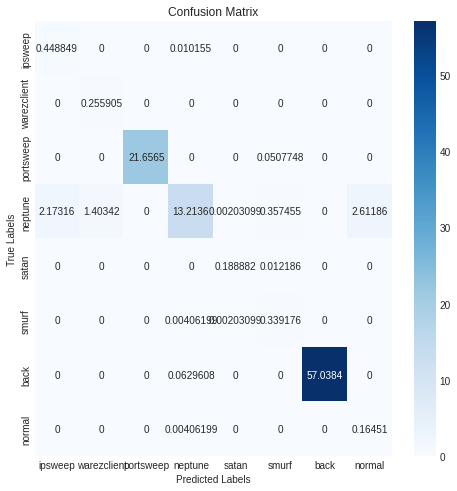

In [ ]:
plot_model_performance(matrix)

### Randomly selected instances for validation
The code below creates a list of lists named 'data' consisting of randomly selected instances from the validation dataset, where only features are included. It also creates a list of it's corresponding true labels named true_labels.

In [ ]:
import random
data = []
true_labels = []

for i in range(10):
  temp = random.randint(0, valid_features.shape[0])
  data.append(valid_features.iloc[temp].tolist())
  true_labels.append(valid_labels.iloc[temp])

for index, ele in enumerate(true_labels):
  true_labels[index] = label_mapping[int(ele)]

print(data)
print(true_labels)

[[0.0, 0.0, 14.0, 9.0, 1.4883707192251517e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 22.0, 9.0, 4.557414217782442e-07, 5.2198796389245644e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01761252446183953, 0.019569471624266144, 0.0, 0.0, 0.0, 0.1, 1.0, 0.0, 0.2, 1.0, 0.9372549019607843, 0.94, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 14.0, 9.0, 7.499542383692626e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 22.0, 9.0, 5.004502321425656e-07, 0.00019983569065435086, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05870841487279843, 0.05870841487279843, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 14.

### Create Dataframe
Create a pandas dataframe called new_data out of the list of lists of instances generated in the code cell above.

In [ ]:
new_data = pd.DataFrame(data)
print(new_data)
new_data.columns = valid_features.columns.tolist()
new_data

    0    1     2    3             4         5   ...   33   34   35   36    37    38
0  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
1  0.0  1.0  22.0  9.0  4.557414e-07  0.000052  ...  0.0  0.0  0.0  0.0  0.00  0.00
2  0.0  0.0  14.0  9.0  7.499542e-07  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
3  0.0  1.0  22.0  9.0  5.004502e-07  0.000200  ...  0.0  0.0  0.0  0.0  0.00  0.00
4  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
5  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.0  0.0  1.0  1.0  0.00  0.00
6  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
7  0.0  0.0  14.0  9.0  7.499542e-07  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
8  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.0  0.0  0.0  0.0  0.00  0.00
9  0.0  1.0  22.0  9.0  7.865866e-05  0.001619  ...  0.0  0.0  0.0  0.0  0.03  0.03

[10 rows x 39 columns]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
1,0.0,1.0,22.0,9.0,4.557414e-07,0.000052,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017613,0.019569,0.0,0.0,0.0,0.1,1.00,0.00,0.2,1.0,0.937255,0.94,0.02,0.0,0.0,0.0,0.0,0.00,0.00
2,0.0,0.0,14.0,9.0,7.499542e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
3,0.0,1.0,22.0,9.0,5.004502e-07,0.000200,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.058708,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
4,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
5,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.459883,0.015656,1.0,1.0,0.0,0.0,0.03,0.06,0.0,1.0,0.031373,0.03,0.07,0.0,0.0,1.0,1.0,0.00,0.00
6,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
7,0.0,0.0,14.0,9.0,7.499542e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
8,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,1.0,0.0,0.0,0.0,0.00,0.00
9,0.0,1.0,22.0,9.0,7.865866e-05,0.001619,0.0,0.0,0.0,0.066667,0.0,1.0,0.001131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.03,0.03


### Validate results
The randomly selected instances of data not used in the training and testing are used to make preidctions of it's label. 

In [ ]:
features_new = np.array(new_data)
pred_labels = nb.predict(features_new)
pred_labels = pred_labels.tolist()

for index, ele in enumerate(pred_labels):
  temp = label_mapping[int(ele)]
  pred_labels[index] = label_mapping[int(ele)]

print("True labels: ", true_labels)
print("Pred labels: ", pred_labels)

True labels:  ['smurf', 'normal', 'smurf', 'normal', 'smurf', 'neptune', 'smurf', 'smurf', 'smurf', 'back']
Pred labels:  ['smurf', 'normal', 'smurf', 'normal', 'smurf', 'neptune', 'smurf', 'smurf', 'smurf', 'back']


## SECTION II
### Using balanced Dataset


### Create Features and Labels
Separate features and labels into two different dataset to create Synthetic data and further split into train and test dataset.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

data_encoded = shuffle(data_encoded)
features_SMOTE = data_encoded.iloc[:, data_encoded.columns != 'label']
labels_SMOTE = data_encoded.iloc[:, data_encoded.columns == 'label']

X_SMOTE = features.to_numpy()
y_SMOTE = labels.to_numpy()
counter_orig = Counter(y_SMOTE)
print(y_SMOTE)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[6. 6. 6. ... 6. 6. 6.]


### Visualize count of Attack types
The bar graph below shows the number of instances for each attack type in the original dataset before creating synthetic instances.

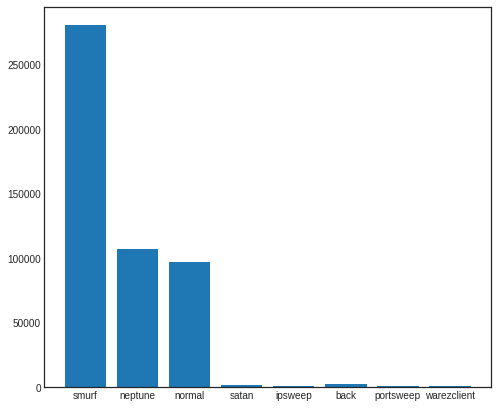

In [ ]:
from matplotlib import pyplot
attack_types = []
for c in counter_orig.keys():
  attack_types.append(label_mapping[c])
  
pyplot.figure(figsize=(8,7))
pyplot.bar(attack_types, counter_orig.values())
pyplot.show()

### SMOTE
Imbalanced classification involves developing predicitve models on classification datasets that have a class inbalance. Synthetic Minority Oversampling Technique, or SMOTE is an approach to address imbalanced dataset where minority class is oversampled. It creates new synthetic instances according to the neighbourhood of each example of the minority class.

In [ ]:
strategy_over = {0:201862, 1:187396, 2:239604, 4:178387, 5:195267, 3:216522, 7:173021}
strategy_under = {6:242063}
over = SMOTE(sampling_strategy = strategy_over)
under = RandomUnderSampler(sampling_strategy = strategy_under)

steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)
X_SMOTE, y_SMOTE = pipeline.fit_resample(X_SMOTE, y_SMOTE)

counter = Counter(y_SMOTE)
print(counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({6.0: 242063, 2.0: 239604, 3.0: 216522, 0.0: 201862, 5.0: 195267, 1.0: 187396, 4.0: 178387, 7.0: 173021})


### Visualize count of Attack types after SMOTE
The bar graph below shows the number of instances for each attack type in the dataset after creating synthetic instances using SMOTE.

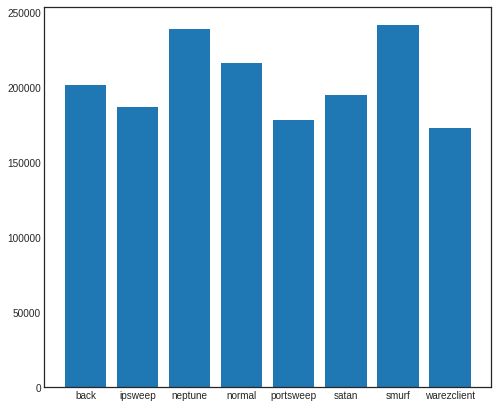

In [ ]:
from matplotlib import pyplot
attack_types = []
for c in counter.keys():
  attack_types.append(label_mapping[c])

pyplot.figure(figsize=(8,7))  
pyplot.bar(attack_types, counter.values())
pyplot.show()

In [ ]:
X_SMOTE = pd.DataFrame(X_SMOTE, columns=features_SMOTE.columns)
y_SMOTE = pd.DataFrame(y_SMOTE, columns=labels_SMOTE.columns)

### Train and Test Data Split

It is absolutely necessary to split the data into training, testing, and validation to make sure Machine Learning algorithms are learning well and can make predictions as accurately as possible. Here we use train_test_split to split 80% of the data as the train, 10% as the test and the rest 10% as the validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split 

train_features_SMOTE, rem_features, train_labels_SMOTE, rem_labels = train_test_split(X_SMOTE, y_SMOTE, train_size=0.8, shuffle=True)
valid_features_SMOTE, test_features_SMOTE, valid_labels_SMOTE, test_labels_SMOTE = train_test_split(rem_features, rem_labels, test_size=0.5, shuffle=True)

print("Train Dataset Feature Shape: ")
print(train_features_SMOTE.shape)
print("Test Dataset Feature Shape: ")
print(test_features_SMOTE.shape)
print("Valid Dataset Feature Shape: ")
print(valid_features_SMOTE.shape)
print("Train Dataset label Shape: ")
print(train_labels_SMOTE.shape)
print("Test Dataset label Shape: ")
print(test_labels_SMOTE.shape)
print("Valid Dataset label Shape: ")
print(valid_labels_SMOTE.shape)

Train Dataset Feature Shape: 
(1307297, 39)
Test Dataset Feature Shape: 
(163413, 39)
Valid Dataset Feature Shape: 
(163412, 39)
Train Dataset label Shape: 
(1307297, 1)
Test Dataset label Shape: 
(163413, 1)
Valid Dataset label Shape: 
(163412, 1)


In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Visualize labels 
As we  can see below, the labels present in the dataframe belong to various types of attack. The proportion of the attacks present in the dataset are more uniform after creating synthetic data.

In [ ]:
lst = []
for i in range(valid_labels_SMOTE.shape[0]):
    lst.append(int(valid_labels_SMOTE.iloc[i]))

print(lst)

[2, 4, 3, 4, 6, 7, 6, 0, 5, 4, 4, 0, 2, 3, 5, 4, 0, 1, 0, 7, 2, 2, 3, 3, 5, 0, 6, 1, 2, 1, 3, 1, 6, 3, 0, 7, 5, 1, 7, 4, 5, 4, 0, 7, 1, 2, 2, 3, 3, 7, 6, 3, 5, 2, 6, 5, 4, 2, 1, 7, 5, 7, 3, 1, 4, 3, 7, 2, 3, 4, 1, 0, 2, 0, 3, 5, 3, 4, 0, 6, 4, 7, 3, 7, 7, 5, 2, 1, 1, 5, 6, 3, 2, 3, 3, 6, 2, 3, 3, 7, 0, 5, 3, 2, 2, 7, 7, 2, 2, 5, 2, 4, 4, 5, 0, 6, 2, 5, 2, 5, 2, 7, 4, 6, 2, 6, 5, 6, 5, 5, 1, 1, 0, 1, 4, 0, 7, 0, 6, 1, 1, 5, 6, 2, 4, 2, 7, 3, 1, 6, 6, 5, 4, 5, 6, 0, 3, 5, 3, 6, 1, 0, 4, 3, 1, 5, 0, 3, 5, 3, 4, 6, 5, 7, 0, 7, 5, 1, 5, 2, 0, 4, 5, 2, 2, 1, 7, 2, 5, 6, 1, 6, 7, 7, 5, 3, 4, 0, 0, 1, 3, 1, 3, 1, 2, 6, 5, 7, 7, 6, 2, 6, 3, 1, 5, 4, 5, 2, 5, 4, 6, 5, 7, 1, 0, 4, 4, 0, 7, 5, 2, 1, 5, 3, 4, 1, 2, 2, 0, 2, 1, 7, 4, 7, 2, 3, 6, 4, 1, 2, 2, 1, 2, 3, 3, 3, 0, 5, 3, 2, 5, 1, 2, 5, 2, 0, 6, 5, 3, 6, 7, 3, 4, 1, 1, 0, 1, 5, 4, 3, 4, 2, 6, 7, 6, 6, 5, 7, 5, 7, 1, 7, 3, 4, 2, 5, 7, 2, 6, 4, 1, 2, 6, 3, 3, 6, 5, 3, 3, 0, 4, 5, 4, 5, 1, 0, 4, 2, 2, 1, 3, 6, 0, 7, 5, 6, 7, 4, 4, 5, 4, 6, 1, 

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Fit model
Fit the model with the features and labels dataframe created from the train_test_split from the new dataset.

In [ ]:
nb.fit(train_features_SMOTE, train_labels_SMOTE)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

### Testing

The test features are used to predict the labels and  test the performance of the Naive Bayes model.

The accuracy of the model using the training data.


In [ ]:
train_pred_labels_SMOTE = nb.predict(train_features_SMOTE)
accuracy, matrix, precision, recall, f1 = get_model_performance(train_labels_SMOTE, train_pred_labels_SMOTE)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.944414314421283
The precision of the model:  0.9429657243910484
The recall of the model:  0.945684777407254
The f1 score of the model:  0.9404585263296047


The accuracy of the model using the test data.

In [ ]:
test_pred_labels_SMOTE = nb.predict(test_features_SMOTE)
accuracy, matrix, precision, recall, f1 = get_model_performance(test_labels_SMOTE, test_pred_labels_SMOTE)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9448575082765753
The precision of the model:  0.9436292715243464
The recall of the model:  0.9457199753807599
The f1 score of the model:  0.9407616229818462


The training accuracy and test accuracy doesn't seem to have a lot of difference. Hence, it shows that the model was not overfit.

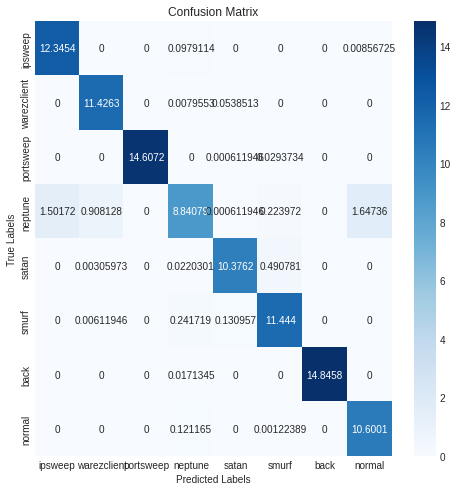

In [ ]:
plot_model_performance(matrix)

In [ ]:
print(valid_features_SMOTE.shape)

(163412, 39)


### Randomly selected instances for validation
The code below creates a list of lists named 'data' consisting of randomly selected instances from the validation dataset, where only features are included. It also creates a list of it's corresponding true labels named true_labels.

In [ ]:
import random
data = []
true_labels_SMOTE = []

for i in range(10):
  temp = random.randint(0, valid_features_SMOTE.shape[0])
  data.append(valid_features_SMOTE.iloc[temp].tolist())
  true_labels_SMOTE.append(valid_labels_SMOTE.iloc[temp])

for index, ele in enumerate(true_labels_SMOTE):
  true_labels_SMOTE[index] = label_mapping[int(ele)]

print(data)
print(true_labels_SMOTE)

[[0.0, 1.0, 22.0, 9.0, 3.4469050571202646e-07, 0.0002056788395038933, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003913894324853229, 0.003913894324853229, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.10196078431372549, 1.0, 1.0, 0.0, 0.04, 0.03, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 19.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03131115459882583, 0.009784735812133072, 1.0, 1.0, 0.0, 0.0, 0.31, 0.19, 0.0, 1.0, 0.0196078431372549, 0.02, 0.08, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 45.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019569471624266144, 0.0019569471624266144, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.20835608747944775, 0.00784313725490196, 0.02, 1.0, 0.02, 1.0, 0.0, 0.0, 0.920327005768148, 1.0], [0.0, 1.0, 40.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019569471624266144, 0.0019569471624266144, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.

### Create Dataframe
Create a pandas dataframe called new_data out of the list of lists of instances generated in the code cell above.

In [ ]:
new_data = pd.DataFrame(data)
print(new_data)
new_data.columns = valid_features_SMOTE.columns.tolist()
new_data

    0    1     2    3             4   ...    34    35    36        37    38
0  0.0  1.0  22.0  9.0  3.446905e-07  ...  0.03  0.00  0.00  0.000000  0.00
1  0.0  1.0  19.0  5.0  0.000000e+00  ...  0.00  1.00  1.00  0.000000  0.00
2  0.0  1.0  45.0  1.0  0.000000e+00  ...  1.00  0.00  0.00  0.920327  1.00
3  0.0  1.0  40.0  4.0  0.000000e+00  ...  0.00  0.00  0.00  1.000000  1.00
4  0.0  1.0  45.0  4.0  0.000000e+00  ...  0.00  0.00  0.00  1.000000  1.00
5  0.0  0.0  14.0  9.0  1.488371e-06  ...  0.00  0.00  0.00  0.000000  0.00
6  0.0  1.0  45.0  4.0  0.000000e+00  ...  0.00  0.00  0.00  1.000000  1.00
7  0.0  1.0  22.0  9.0  7.865866e-05  ...  0.00  0.01  0.01  0.020000  0.02
8  0.0  1.0  45.0  1.0  0.000000e+00  ...  0.00  0.00  0.00  1.000000  1.00
9  0.0  1.0  22.0  9.0  3.799934e-07  ...  0.00  0.00  0.00  0.000000  0.00

[10 rows x 39 columns]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,22.0,9.0,3.446905e-07,0.000206,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.101961,1.000000,1.00,0.000000,0.04,0.03,0.00,0.00,0.000000,0.00
1,0.0,1.0,19.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031311,0.009785,1.0,1.0,0.0,0.0,0.31,0.19,0.0,1.000000,0.019608,0.02,0.080000,0.00,0.00,1.00,1.00,0.000000,0.00
2,0.0,1.0,45.0,1.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.00,0.00,0.0,0.208356,0.007843,0.02,1.000000,0.02,1.00,0.00,0.00,0.920327,1.00
3,0.0,1.0,40.0,4.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.00,0.00,0.0,1.000000,0.003922,0.00,0.740000,1.00,0.00,0.00,0.00,1.000000,1.00
4,0.0,1.0,45.0,4.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.00,0.00,0.0,1.000000,0.003922,0.00,0.522311,1.00,0.00,0.00,0.00,1.000000,1.00
5,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.000000,1.00,0.00,0.00,0.00,0.000000,0.00
6,0.0,1.0,45.0,4.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.00,0.00,0.0,1.000000,0.003922,0.00,1.000000,1.00,0.00,0.00,0.00,1.000000,1.00
7,0.0,1.0,22.0,9.0,7.865866e-05,0.001619,0.0,0.0,0.0,0.066667,0.0,1.0,0.001131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.000000,0.00,0.00,0.01,0.01,0.020000,0.02
8,0.0,1.0,45.0,1.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277886,0.031311,0.0,0.0,1.0,1.0,0.11,0.06,0.0,1.000000,0.062745,0.06,0.070000,0.00,0.00,0.00,0.00,1.000000,1.00
9,0.0,1.0,22.0,9.0,3.799934e-07,0.001805,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00


### Validate results
The randomly selected instances of data not used in the training and testing are used to make preidctions of it's label. 

In [ ]:
features_new_SMOTE = np.array(new_data)
pred_labels_SMOTE = nb.predict(features_new_SMOTE)
pred_labels_SMOTE = pred_labels_SMOTE.tolist()

for index, ele in enumerate(pred_labels_SMOTE):
  temp = label_mapping[int(ele)]
  pred_labels_SMOTE[index] = label_mapping[int(ele)]

print("True labels: ", true_labels_SMOTE)
print("Pred labels: ", pred_labels_SMOTE)

True labels:  ['normal', 'neptune', 'ipsweep', 'portsweep', 'portsweep', 'smurf', 'portsweep', 'back', 'neptune', 'normal']
Pred labels:  ['warezclient', 'neptune', 'ipsweep', 'portsweep', 'portsweep', 'smurf', 'portsweep', 'back', 'neptune', 'back']
